<b><font size="8">Identifying Contributing Factors to Collision Severity in Sacramento County, CA. </font><b>

# Introduction
Each year, more than 40,000 road users get killed on the roadways in the US. Despite considerable advances in the vehicle industry and the safety of occupants, the existing safety trend is yet a major concern. Addressing this trend needs a thorough understanding of collision causes. In other words, identifying the collision causes is one of the major steps towards a successful, data-driven safety enhancement. To this end, we explored the contributing factors to collision and their higher injury severity in Sacramento, CA.

Below is the libraries that we need tro tackle this problem:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# models:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


# model selection libraries
from sklearn.model_selection import RepeatedStratifiedKFold, KFold, train_test_split, RepeatedKFold, GridSearchCV
from sklearn.feature_selection import RFECV

# evaluation metrics
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report, jaccard_score, log_loss, plot_confusion_matrix

# Data
For this study, we used the collision data in unincorporated Sacramento County for the most recent 5-year period, i.e., 2015 through 2019. The data is publicly available through the SWITRS collision database. A review of the data identifies 99,590 collisions during the study period. The figure below shows clearly that there is no downward trend in the frequency of collisions. This is exactly the issue that we were talking about that needs a close investigation.

In [2]:
# during the read process, I got an error that some columns have mixed data types, which caused some issues (like pcf_violation category was showing two varioues counts for each catrgoey like 3:26000 and 3:14000)
# There were two solutions, first determine the dtype when reading the file, next set the low_memory equal to False. I chose second and it fixed the issue.
collision_df = pd.read_csv('Sac_County_All_Collisions_2015-2019.txt', sep='\t', low_memory=False)

In [3]:
collision_df.shape[0]

99590

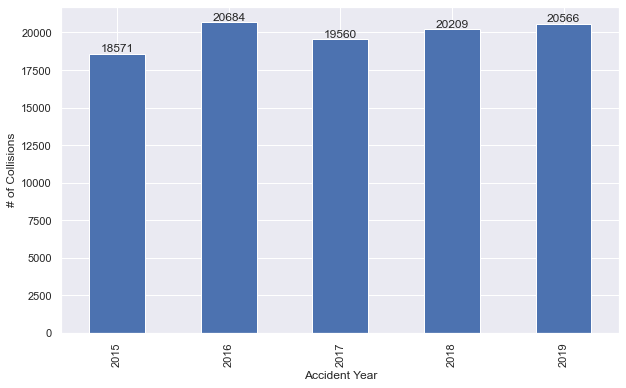

In [4]:
# I personally like seaborn defaults better, this is how we set up the figure format to those of seaborn
sns.set()

# set the figure size
plt.figure(figsize=(10,6)) 

# group the collisions by year and make the bar chart
ax = collision_df.groupby(by='accident_year').count()['case_id'].plot(kind='bar'); 

# adding annual collision frequencies as labels to bars
labels = collision_df.groupby(by='accident_year').count()['case_id'].tolist() # cretae a list of collision frequency per year
rects = ax.patches
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')

# adding axis labels
plt.xlabel('Accident Year');
plt.ylabel('# of Collisions');
plt.show()

Before digging deep into the data analysis portion, we need to prepare the data for analysis and do some preliminary data exploration. So, in this section of the analysis, we will do the "data preparation" part of the analysis, which includes several aspects such as data cleaning, outlier removal, correlation identification, feature engineering, etc. Let's look at some info, like the potential covariates and their types as well as the number of data points:

In [5]:
pd.set_option("max_rows", None)
collision_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99590 entries, 0 to 99589
Data columns (total 76 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   case_id                  99590 non-null  int64  
 1   accident_year            99590 non-null  int64  
 2   proc_date                99590 non-null  int64  
 3   juris                    99590 non-null  object 
 4   collision_date           99590 non-null  int64  
 5   collision_time           99590 non-null  int64  
 6   officer_id               99547 non-null  object 
 7   reporting_district       24219 non-null  object 
 8   day_of_week              99590 non-null  int64  
 9   chp_shift                99590 non-null  int64  
 10  population               99590 non-null  int64  
 11  cnty_city_loc            99590 non-null  int64  
 12  special_cond             99590 non-null  int64  
 13  beat_type                99590 non-null  int64  
 14  chp_beat_type         

By domain knowledge and common sense, we know there are many of these variables that really do not affect the collision probability and severity. We need to  drop them from the dataframe. We first provide a list of the columns to copy the entries from, which is easier:

In [6]:
collision_df = collision_df[['day_of_week', 'distance', 'intersection', 'weather_1',
       'collision_severity', 'pcf_viol_category', 'type_of_collision',
       'lighting', 'alcohol_involved']]

Much better now! A few things to consider here:
- Most of the variables of interest are categorical ones.
- There is a data dictionary provided when you download the data. We use that data dictionary to decode all the categorical variabes.
- We still need to clean the data before drawing any conclusion.

Let's keep mooving! But first we need to determine the dtypes before defining the dictionaries.

In [7]:
collision_df.dtypes

day_of_week             int64
distance              float64
intersection           object
weather_1              object
collision_severity      int64
pcf_viol_category      object
type_of_collision      object
lighting               object
alcohol_involved       object
dtype: object

## Data Clean-up

As we see, there are some values in the categories that might be of no interest. Like "-" in the pcf (primary contributing factor) which is supposed to shed some lights on the data. We explore those "-"s and remove them if many of them are available. Let's see:

In [8]:
collision_df.weather_1.value_counts()

A    80122
B    14773
C     4138
E      337
-      109
F       86
G       15
D       10
Name: weather_1, dtype: int64

In [9]:
# 109 -'s, we will remove them as they are not that many:

collision_df = collision_df[collision_df.weather_1 != "-"]
collision_df.weather_1.value_counts()

A    80122
B    14773
C     4138
E      337
F       86
G       15
D       10
Name: weather_1, dtype: int64

In [10]:
collision_df.pcf_viol_category.value_counts()

3     36769
8     16665
9     10821
7      8696
1      7419
12     6151
21     2679
5      1932
0      1851
18     1587
11     1109
6       802
10      720
4       687
17      680
22      462
-       207
16       91
13       77
2        50
14       17
15        9
Name: pcf_viol_category, dtype: int64

In [11]:
# 207 -'s, not too many, we will remove those guys, too (note: by trial and error we noticed that there is an extra space after the hyphen!):

collision_df = collision_df[collision_df.pcf_viol_category != "- "]
collision_df.pcf_viol_category.value_counts()

3     36769
8     16665
9     10821
7      8696
1      7419
12     6151
21     2679
5      1932
0      1851
18     1587
11     1109
6       802
10      720
4       687
17      680
22      462
16       91
13       77
2        50
14       17
15        9
Name: pcf_viol_category, dtype: int64

In [12]:
collision_df.lighting.value_counts()

A    67278
C    21488
D     6963
B     3284
E      146
-      115
Name: lighting, dtype: int64

In [13]:
# 115 -'s, again, not too many, let's remove them:

collision_df = collision_df[collision_df.lighting != "-"]
collision_df.lighting.value_counts()

A    67278
C    21488
D     6963
B     3284
E      146
Name: lighting, dtype: int64

Also, we know that NaN in alcohol_involved column basically means, No. So, let's fix it.

In [14]:
collision_df.alcohol_involved.replace({np.nan: "No", "Y": "Yes"}, inplace=True)
collision_df.head()

,day_of_week,distance,intersection,weather_1,collision_severity,pcf_viol_category,type_of_collision,lighting,alcohol_involved
0,4,3590.0,N,A,1,8,E,D,No
1,5,52.0,N,A,1,11,G,C,Yes
2,1,514.0,N,A,1,1,E,C,Yes
4,3,67.0,N,A,1,1,E,C,Yes
5,3,620.0,N,A,1,0,G,D,No


## Decoding Catrgorical Variables

As the first step, we create several data dictionaries for every single categorical variable and decode the variables, here are the dictionaries:

In [15]:
day_of_week_dic = {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday', 7: 'Sunday'}
weather_1_dic = {'A': 'Clear', 'B': 'Cloudy', 'C': 'Raining', 'D': 'Snowing', 'E': 'Fog', 'F': 'Other', 'G': 'Wind',  '-': 'Not Stated'}
collision_severity_dic = {1: 'Fatal', 2: 'Injury (Severe)', 3: 'Injury (Other Visible)', 4: 'Injury (Complaint of Pain)', 0: 'PDO'}
pcf_viol_category_dic = {'1': 'Driving or Bicycling Under the Influence of Alcohol or Drug', '2': 'Impeding Traffic', '3': 'Unsafe Speed', '4': 'Following Too Closely', '5': 'Wrong Side of Road',
                         '6': 'Improper Passing', '7': 'Unsafe Lane Change', '8': 'Improper Turning', '9': 'Automobile Right of Way', '10': 'Pedestrian Right of Way', '11': 'Pedestrian Violation',
                         '12': 'Traffic Signals and Signs', '13': 'Hazardous Parking', '14': 'Lights', '15': 'Brakes', '16': 'Other Equipment', '17': 'Other Hazardous Violation',
                         '18': 'Other Than Driver (or Pedestrian)', '19': 'N/A', '20': 'N/A', '21': 'Unsafe Starting or Backing', '22': 'Other Improper Driving', 
                         '23': 'Pedestrian or Other Under the Influence of Alcohol or Drug', '24': 'Fell Asleep', '0': 'Unknown', '-': 'Not Stated'}
type_of_collision_dic = {'A': 'Head-On', 'B': 'Sideswipe', 'C': 'Rear End', 'D': 'Broadside', 'E': 'Hit Object', 'F': 'Overturned', 'G': 'Vehicle/Pedestrian', 'H': 'Other', '-' : 'Not Stated'}
lighting_dic = {'A': 'Daylight', 'B': 'Dusk - Dawn', 'C': 'Dark - Street Lights', 'D': 'Dark - No Street Lights', 'E': 'Dark - Street Lights Not Functioning', '-': 'Not Stated'}

In [16]:
# before using the dictionaries, given that some of them map from an integer, let's make sure the variable types in the dataframe and the dictionaries are consistent:

collision_df.dtypes

day_of_week             int64
distance              float64
intersection           object
weather_1              object
collision_severity      int64
pcf_viol_category      object
type_of_collision      object
lighting               object
alcohol_involved       object
dtype: object

Alright! Then we map the alphanumerical values of the variables to these dictionaries, like below, and create a new dataframe with the decoded variables:

In [17]:
# cretaing a new dataframe from the original one. We would like to keep the original one:

collision_dec = collision_df.copy()

In [18]:
# given that we need to do the tasks (stripping and mapping) multiple times, it's a good practice to put them in a loop, for better readability:

columns = ['day_of_week', 'weather_1', 'collision_severity', 'pcf_viol_category', 'type_of_collision', 'lighting']
columns_dic = [day_of_week_dic, weather_1_dic, collision_severity_dic, pcf_viol_category_dic, type_of_collision_dic, lighting_dic]
for col, dic in zip(columns, columns_dic):
    collision_dec[col] = collision_dec[col].map(dic)

Let's take a look at the new dataframe:

In [19]:
collision_dec.head()

,day_of_week,distance,intersection,weather_1,collision_severity,pcf_viol_category,type_of_collision,lighting,alcohol_involved
0,Thursday,3590.0,N,Clear,Fatal,Improper Turning,Hit Object,Dark - No Street Lights,No
1,Friday,52.0,N,Clear,Fatal,Pedestrian Violation,Vehicle/Pedestrian,Dark - Street Lights,Yes
2,Monday,514.0,N,Clear,Fatal,Driving or Bicycling Under the Influence of Al...,Hit Object,Dark - Street Lights,Yes
4,Wednesday,67.0,N,Clear,Fatal,Driving or Bicycling Under the Influence of Al...,Hit Object,Dark - Street Lights,Yes
5,Wednesday,620.0,N,Clear,Fatal,Unknown,Vehicle/Pedestrian,Dark - No Street Lights,No


## Feature Engineering

Based on my previous experience working on the SWITRS datasets, I know they traditionally assign a collision to an intersection when the distance to the intersection is zero. We know that can't be true. So, we changed this parameter by specifying a coliision to be an intersection-related collision when it happens within 250 feet of an intersection (based on the Highway Safety Manual). We use the distance parameter for this purpose then we drop it.

In [20]:
collision_dec.intersection = collision_dec['distance'].apply(lambda x: 'Yes' if x <= 250 else 'No')
collision_dec.drop(columns='distance', inplace=True)
collision_dec.head()

,day_of_week,intersection,weather_1,collision_severity,pcf_viol_category,type_of_collision,lighting,alcohol_involved
0,Thursday,No,Clear,Fatal,Improper Turning,Hit Object,Dark - No Street Lights,No
1,Friday,Yes,Clear,Fatal,Pedestrian Violation,Vehicle/Pedestrian,Dark - Street Lights,Yes
2,Monday,No,Clear,Fatal,Driving or Bicycling Under the Influence of Al...,Hit Object,Dark - Street Lights,Yes
4,Wednesday,Yes,Clear,Fatal,Driving or Bicycling Under the Influence of Al...,Hit Object,Dark - Street Lights,Yes
5,Wednesday,No,Clear,Fatal,Unknown,Vehicle/Pedestrian,Dark - No Street Lights,No


Also, as mentioned in the problem statement, we would like to see how various factors affect the severity of the collisions. For this we specify two groups of severity outcome, one is "PDO" and the other is "Non-PDO", with the latter containing all injury and fatal collisions. Here is how we do that:

In [21]:
collision_dec['severity'] = collision_dec['collision_severity'].apply(lambda x: "PDO" if x == "PDO" else "Non-PDO")
collision_dec.head()

,day_of_week,intersection,weather_1,collision_severity,pcf_viol_category,type_of_collision,lighting,alcohol_involved,severity
0,Thursday,No,Clear,Fatal,Improper Turning,Hit Object,Dark - No Street Lights,No,Non-PDO
1,Friday,Yes,Clear,Fatal,Pedestrian Violation,Vehicle/Pedestrian,Dark - Street Lights,Yes,Non-PDO
2,Monday,No,Clear,Fatal,Driving or Bicycling Under the Influence of Al...,Hit Object,Dark - Street Lights,Yes,Non-PDO
4,Wednesday,Yes,Clear,Fatal,Driving or Bicycling Under the Influence of Al...,Hit Object,Dark - Street Lights,Yes,Non-PDO
5,Wednesday,No,Clear,Fatal,Unknown,Vehicle/Pedestrian,Dark - No Street Lights,No,Non-PDO


In [22]:
# let's see how many data points exists under each category:

collision_dec.severity.value_counts()

PDO        57040
Non-PDO    42119
Name: severity, dtype: int64

## Final Feature Clean-up

There are still a few steps to be taken to make the data ready for the next step, which is Exploratory Data Analysis (EDA). First, we need to see if any of the categories under each variable are essentially the same, so they need to be combined. Also, as part of the pre-processing, we need to convert categorical variables into 0-1 values. That being said, there are several categories under various features, that do not have many observations. It's a good practice to combine low-observation categories under each variable into one category, called something like "other". There is no cut-off threshold for this purpose, mostly based on the domain experience and engineering judgement. Below, we apply these two steps to the categorcal variables.

### Day of Week

We just seggregate them dat of week into two groups: Weekend and Weekday

In [23]:
collision_dec['day'] = collision_dec.day_of_week.apply(lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekday')

In [24]:
collision_dec.day.value_counts()

Weekday    76174
Weekend    22985
Name: day, dtype: int64

### Weather

In [25]:
collision_dec.weather_1.value_counts()

Clear      79849
Cloudy     14749
Raining     4120
Fog          335
Other         81
Wind          15
Snowing       10
Name: weather_1, dtype: int64

For weather, this is what I did:
- Combine clear and cloudy as they are essentially the same (think this way, there should be no difference in the probability of a different injury severity if the weather is cloudy).
- Combine raining and snowing and make a new category called Precipitation
- Combine other categories into Other.

In [26]:
collision_dec['weather'] = collision_dec.weather_1.apply(lambda x: "Clear/Cloudy" if x in ['Clear', 'Cloudy'] else "Precipitation" if x in ['Raining', 'Snowing'] else "Other")

# we could alternatively use the following:
# collision_dec['weather'] = pd.Series(["Clear/Cloudy" if x in ['Clear', 'Cloudy'] else "Precipitation" if x in ['Raining', 'Snowing'] else "Other" for x in collision_dec.weather_1])

In [27]:
collision_dec.weather.value_counts()

Clear/Cloudy     94598
Precipitation     4130
Other              431
Name: weather, dtype: int64

### Primary Contributing Factor

In [28]:
collision_dec.pcf_viol_category.value_counts()

Unsafe Speed                                                   36739
Improper Turning                                               16645
Automobile Right of Way                                        10807
Unsafe Lane Change                                              8690
Driving or Bicycling Under the Influence of Alcohol or Drug     7407
Traffic Signals and Signs                                       6140
Unsafe Starting or Backing                                      2678
Wrong Side of Road                                              1929
Unknown                                                         1842
Other Than Driver (or Pedestrian)                               1587
Pedestrian Violation                                            1106
Improper Passing                                                 802
Pedestrian Right of Way                                          717
Following Too Closely                                            687
Other Hazardous Violation         

- We combine several categories into the Other category:
['Unknown','Other Hazardous Violation','Impeding Traffic', 'Other Than Driver (or Pedestrian)', 'Other Equipment', 'Other Improper Driving', 'Brakes', 'Lights', 'Hazardous Parking']

- Also, we combine the following two into "Pedestrian Collision" category: ['Pedestrian Right of Way', 'Pedestrian Violation']

In [29]:
collision_dec['primary_cont_fact'] = collision_dec.pcf_viol_category.apply(lambda x: 'Other' if x in ['Unknown','Other Hazardous Violation','Impeding Traffic',
    'Other Than Driver (or Pedestrian)', 'Other Equipment', 'Other Improper Driving', 'Brakes', 'Lights', 'Hazardous Parking']
    else 'Pedestrian Collision' if x in ['Pedestrian Right of Way', 'Pedestrian Violation'] else x)

In [30]:
collision_dec.primary_cont_fact.value_counts()

Unsafe Speed                                                   36739
Improper Turning                                               16645
Automobile Right of Way                                        10807
Unsafe Lane Change                                              8690
Driving or Bicycling Under the Influence of Alcohol or Drug     7407
Traffic Signals and Signs                                       6140
Other                                                           4812
Unsafe Starting or Backing                                      2678
Wrong Side of Road                                              1929
Pedestrian Collision                                            1823
Improper Passing                                                 802
Following Too Closely                                            687
Name: primary_cont_fact, dtype: int64

### Type of Collision

In [31]:
collision_dec.type_of_collision.value_counts()

Rear End              37775
Broadside             19171
Sideswipe             16663
Hit Object            14722
Head-On                3823
Vehicle/Pedestrian     2437
Other                  2376
Overturned             1614
Not Stated              578
Name: type_of_collision, dtype: int64

For this variable, we just combine "Other" and "Not Stated" into the "Other" category:

In [32]:
collision_dec['collision_type'] = collision_dec.type_of_collision.apply(lambda x: 'Other' if x in ['Other', 'Not Stated'] else x)

In [33]:
collision_dec.collision_type.value_counts()

Rear End              37775
Broadside             19171
Sideswipe             16663
Hit Object            14722
Head-On                3823
Other                  2954
Vehicle/Pedestrian     2437
Overturned             1614
Name: collision_type, dtype: int64

### Lighting

In [34]:
collision_dec.lighting.value_counts()

Daylight                                67278
Dark - Street Lights                    21488
Dark - No Street Lights                  6963
Dusk - Dawn                              3284
Dark - Street Lights Not Functioning      146
Name: lighting, dtype: int64

For lighting, we just combine the two variables ['Dark - No Street Lights', 'Dark - Street Lights Not Functioning'] into 'Dark - No Light', as they both are technically the same.

In [35]:
collision_dec['light'] = collision_dec.lighting.apply(lambda x: 'Dark - No Light' if x in ['Dark - No Street Lights', 'Dark - Street Lights Not Functioning'] else x)

In [36]:
collision_dec.light.value_counts()

Daylight                67278
Dark - Street Lights    21488
Dark - No Light          7109
Dusk - Dawn              3284
Name: light, dtype: int64

## Removing Non-required Columns

As you noticed, we created several additional columns from old ones during the feature engineering process, let's drop them:

In [37]:
collision_dec.head()

,day_of_week,intersection,weather_1,collision_severity,pcf_viol_category,type_of_collision,lighting,alcohol_involved,severity,day,weather,primary_cont_fact,collision_type,light
0,Thursday,No,Clear,Fatal,Improper Turning,Hit Object,Dark - No Street Lights,No,Non-PDO,Weekday,Clear/Cloudy,Improper Turning,Hit Object,Dark - No Light
1,Friday,Yes,Clear,Fatal,Pedestrian Violation,Vehicle/Pedestrian,Dark - Street Lights,Yes,Non-PDO,Weekday,Clear/Cloudy,Pedestrian Collision,Vehicle/Pedestrian,Dark - Street Lights
2,Monday,No,Clear,Fatal,Driving or Bicycling Under the Influence of Al...,Hit Object,Dark - Street Lights,Yes,Non-PDO,Weekday,Clear/Cloudy,Driving or Bicycling Under the Influence of Al...,Hit Object,Dark - Street Lights
4,Wednesday,Yes,Clear,Fatal,Driving or Bicycling Under the Influence of Al...,Hit Object,Dark - Street Lights,Yes,Non-PDO,Weekday,Clear/Cloudy,Driving or Bicycling Under the Influence of Al...,Hit Object,Dark - Street Lights
5,Wednesday,No,Clear,Fatal,Unknown,Vehicle/Pedestrian,Dark - No Street Lights,No,Non-PDO,Weekday,Clear/Cloudy,Other,Vehicle/Pedestrian,Dark - No Light


In [38]:
collision_dec.drop(columns=['day_of_week', 'weather_1', 'collision_severity', 'pcf_viol_category', 'type_of_collision','lighting'], inplace=True)
collision_dec.head()

,intersection,alcohol_involved,severity,day,weather,primary_cont_fact,collision_type,light
0,No,No,Non-PDO,Weekday,Clear/Cloudy,Improper Turning,Hit Object,Dark - No Light
1,Yes,Yes,Non-PDO,Weekday,Clear/Cloudy,Pedestrian Collision,Vehicle/Pedestrian,Dark - Street Lights
2,No,Yes,Non-PDO,Weekday,Clear/Cloudy,Driving or Bicycling Under the Influence of Al...,Hit Object,Dark - Street Lights
4,Yes,Yes,Non-PDO,Weekday,Clear/Cloudy,Driving or Bicycling Under the Influence of Al...,Hit Object,Dark - Street Lights
5,No,No,Non-PDO,Weekday,Clear/Cloudy,Other,Vehicle/Pedestrian,Dark - No Light


## Exploratory Data Analysis (EDA)

OK...the most fun part! We need to get a better understanding of the data, like the big picture. We mainly do so using visualization. Let's keep moving...

We use crosstab to see if there is any visible correlation between the categorical variables and the dependent variable (here, severity):

### Intersection

It seems collisions that happened at intersections do show some variations in collision severity. Collisions at intersections seem to be slightly more severe than those that happened at segments.	

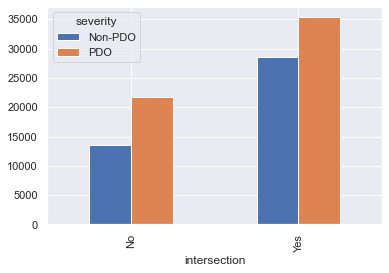

In [39]:
pd.crosstab(collision_dec.intersection, collision_dec.severity).plot(kind='bar')

### Alcohol Involved

As we can see from the chart above, alcohol involvement seems to affect the severity of collisions. Collisions with alcohol involvement tend to be more severe than those with no alcohol involvement.

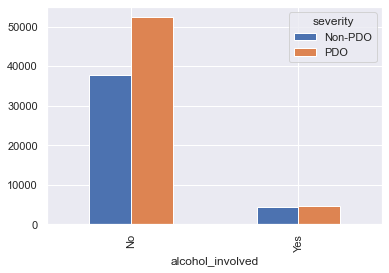

In [40]:
pd.crosstab(collision_dec.alcohol_involved, collision_dec.severity).plot(kind='bar')

### Day

Based on the figure below, collisions that happened during the weekend seem to be of higher severity.

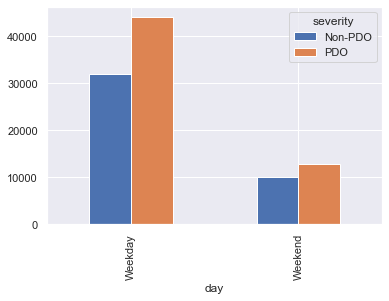

In [41]:
pd.crosstab(collision_dec.day, collision_dec.severity).plot(kind='bar')

### Weather

It is not clear based on the figure below to claim weather can affect the injury severity. However, historically the weather has played a role in affecting the injury severity, so we will keep it until we investigate it through our models.

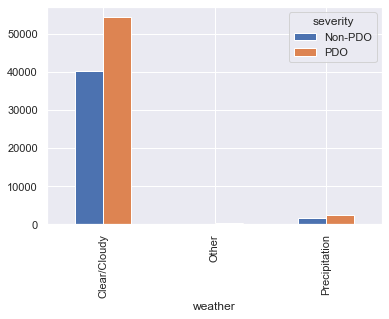

In [42]:
pd.crosstab(collision_dec.weather, collision_dec.severity).plot(kind='bar')

### Primary Contributing Factor

This parameter is probably the most affecting and interesting one. Some interesting patterns can be found based on the figure below. For instance, Automobile Right-of-Way disproportionally accounts for higher Non-PDO collisions than PDO.

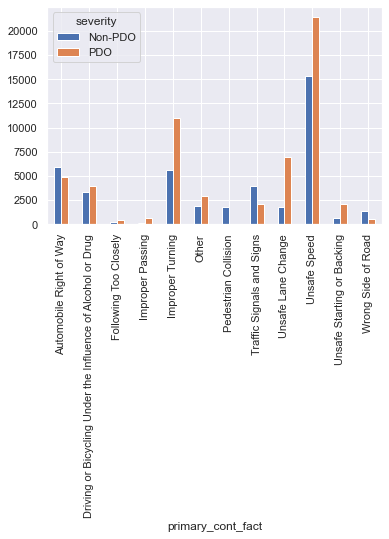

In [43]:
pd.crosstab(collision_dec.primary_cont_fact, collision_dec.severity).plot(kind='bar')

### Collision Type

Collision type also clearly explains the difference between PDO and Non-PDO collisions, as can be seen by the figure. 

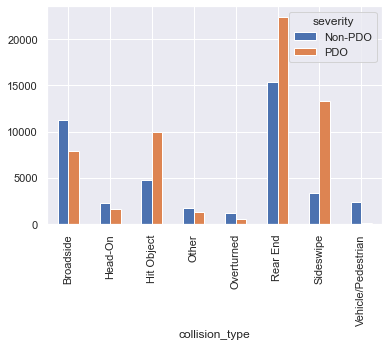

In [44]:
pd.crosstab(collision_dec.collision_type, collision_dec.severity).plot(kind='bar')

### Lighting Condition

The lighting condition also seems to be affecting the severity outcome of the collisions, as perceived by the figure below. 

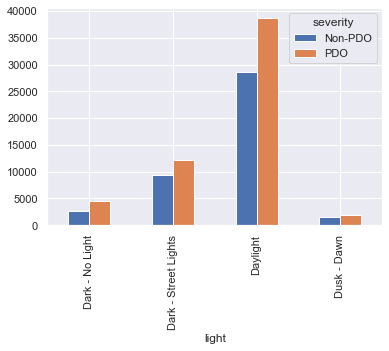

In [45]:
pd.crosstab(collision_dec.light, collision_dec.severity).plot(kind='bar')

## Creating Dummy Variables

As I mentioned before, you can't feed categorical variables into machine learning models. A way around it is to create dummy variables, which seggregates each variable into its categories and assigns 0 r 1 if that specific catrgoy is seen in that data point. There are multiple ways to do that, I use get_dummies method of pandas library for this purpose:

In [46]:
x = collision_dec[['intersection', 'alcohol_involved', 'day', 'weather', 'primary_cont_fact', 'collision_type', 'light']]
y = collision_dec[['severity']]

In [47]:
x_onehot = pd.get_dummies(x)
x_onehot.head()

,intersection_No,intersection_Yes,alcohol_involved_No,alcohol_involved_Yes,day_Weekday,day_Weekend,weather_Clear/Cloudy,weather_Other,weather_Precipitation,primary_cont_fact_Automobile Right of Way,...,collision_type_Hit Object,collision_type_Other,collision_type_Overturned,collision_type_Rear End,collision_type_Sideswipe,collision_type_Vehicle/Pedestrian,light_Dark - No Light,light_Dark - Street Lights,light_Daylight,light_Dusk - Dawn
0,1,0,1,0,1,0,1,0,0,0,...,1,0,0,0,0,0,1,0,0,0
1,0,1,0,1,1,0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,0
2,1,0,0,1,1,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,0,1,0,1,1,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
5,1,0,1,0,1,0,1,0,0,0,...,0,0,0,0,0,1,1,0,0,0


In [48]:
# let's see how many dummy variables we have:

len(x_onehot.columns)

33

## Feature Selection

We know that not all the features can affect the severity of the collisions. Also, think about that: "we need to one-hot encode all the categorical variables, which means we will be left with so many 0-1 variables. Adding all those variables might cause overfitting which means the developed model will not perform well on the test dataset." A good way around this is to use feature selection. There are several methods to do so, but I personally like "Recursive feature elimination with cross-validation" or RFECV. Here is how we implemnt it:

First we leave out a portion of the data, 25%, for final evaluation, and split the data to train and test datasets using startification method to ensure enough proportion of the observation is present in both train and test sets:

In [49]:
X_train, X_test, y_train, y_test = train_test_split(x_onehot, y, test_size=0.25, stratify=collision_dec.severity)

You can see below how the propotion is preserved:

In [50]:
collision_dec.severity.value_counts()/collision_dec.severity.count()*100

PDO        57.523775
Non-PDO    42.476225
Name: severity, dtype: float64

In [51]:
y_train.severity.value_counts()/y_train.severity.count()*100

PDO        57.523968
Non-PDO    42.476032
Name: severity, dtype: float64

In [52]:
y_test.severity.value_counts()/y_test.severity.count()*100

PDO        57.523195
Non-PDO    42.476805
Name: severity, dtype: float64

Then we initiate a cross-validation iterable. I personally like RepeatedStratifiedCV with 10 folds as it is known to be the practice for classification. However, this method creates repeat*fold models. For instance, if we have 10 folds and 3 repeats, it creates 30 models. This method is computetionally expensive. So we may stick to other methods. Even as simple as cv = 5!

In [53]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

We also need an estimator that spits out the either "coef_" or "feature_importance_". I use logistic regression for this purpose:

In [54]:
estimator = LogisticRegression()

Finally we create the "selector" and apply it to our data. We ended up using a simple cv (cv=5) given that the dataset was large and my computer could not handle RepeatedStratifiedKFold CV!

In [55]:
selector = RFECV(estimator, step=1, cv=5)
selector.fit(X_train, y_train.values.ravel())

RFECV(cv=5, estimator=LogisticRegression())

The next step is to see what parameters were identified as the top ones, we can see those by the following code:

In [56]:
selector.ranking_

array([10, 11,  7,  1, 16,  5,  4, 14, 18,  3,  6,  1,  1,  1,  1,  1,  1,
        1, 17,  1,  1, 13, 12,  1,  2,  1,  1,  1,  1,  1, 15,  8,  9])

Let's do something cool. We want to see the number of features vs. cross-validation score and see how it looks and how it leads to this number of features selected:

Optimal number of features : 16


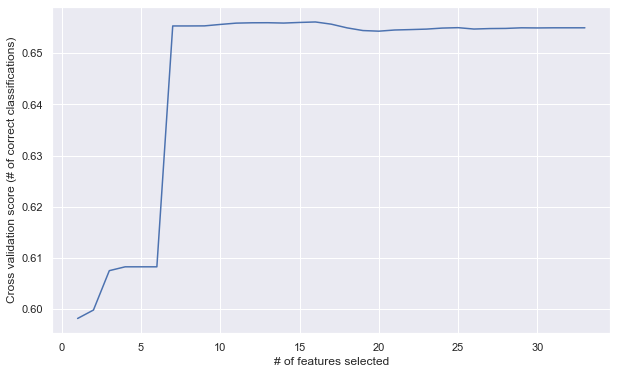

In [57]:
print("Optimal number of features : %d" % selector.n_features_)

plt.figure(figsize=(10,6))
plt.xlabel("# of features selected")
plt.ylabel("Cross validation score (# of correct classifications)")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.show()

OK, what are those features? Let's figure that out:

In [58]:
cols = selector.get_support(indices=True)
X_train_select = X_train.iloc[:,cols]
X_test_select = X_test.iloc[:, cols]

In [59]:
X_train_select.columns

Index(['alcohol_involved_Yes', 'primary_cont_fact_Following Too Closely',
       'primary_cont_fact_Improper Passing',
       'primary_cont_fact_Improper Turning', 'primary_cont_fact_Other',
       'primary_cont_fact_Pedestrian Collision',
       'primary_cont_fact_Traffic Signals and Signs',
       'primary_cont_fact_Unsafe Lane Change',
       'primary_cont_fact_Unsafe Starting or Backing',
       'primary_cont_fact_Wrong Side of Road', 'collision_type_Hit Object',
       'collision_type_Overturned', 'collision_type_Rear End',
       'collision_type_Sideswipe', 'collision_type_Vehicle/Pedestrian',
       'light_Dark - No Light'],
      dtype='object')

We even took one step further and used Statsmodels Logit model to see if the identified parameters are statistically significant. Let's see:

In [60]:
# for the statsmodel, the y variable should be 0-1:
y_train_dummy = y_train.severity.apply(lambda x: 1 if x == "Non-PDO" else 0)

import statsmodels.api as sm
logit_model=sm.Logit(y_train_dummy,X_train_select)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.618066
         Iterations 7
                                       Results: Logit
Model:                        Logit                     Pseudo R-squared:          0.093     
Dependent Variable:           severity                  AIC:                       91961.8287
Date:                         2020-10-31 12:29          BIC:                       92109.2974
No. Observations:             74369                     Log-Likelihood:            -45965.   
Df Model:                     15                        LL-Null:                   -50703.   
Df Residuals:                 74353                     LLR p-value:               0.0000    
Converged:                    1.0000                    Scale:                     1.0000    
No. Iterations:               7.0000                                                         
--------------------------------------------------------------------------------------------

We see that almost all the features have p-values less than 0.05, which is a good sign. We keep all those features and continue to model development step.

# Metodology

## Model Identification

In this study, we considered three models to fit the data. These models include:
- Logistic Regression
- Decision Tree Analysis
- kNN

Each of these models has its own hyperparameters that need to be tuned to get the best result out of them. This process needs a method, called the grid search. The way it works is that we identify the hyperparameters that we want to explore for each of the models and then run each model using those hyperparameters. For each model, we then get a set of hyperparameter(s) that help us achieve the best results (scores) for that specific model. To do so, we need to define a function, as below:

In [61]:
def best_model(X,y):
    models = {
        'logistic_regression' : {
            'model': LogisticRegression(),
            'params': {
                'C': [0.01, 0.1, 1, 5, 10],
                'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
            }
        },
        'decision_tree': {
            'model': DecisionTreeClassifier(),
            'params': {
                'criterion': ['gini', 'entropy'],
                'splitter': ['best', 'random'],
                'max_depth': [5, 6, 7, 8, 9, 10]
            }
        },
        'kNN': {
            'model': KNeighborsClassifier(),
            'params': {
                'n_neighbors' : [3, 4, 5, 6, 7, 8, 9, 10],
                'weights': ['uniform', 'distance'],
                'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']
            }
        }
    }
    scores = []
    for model_name, config in models.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=5, return_train_score=False) # you can use whatever cv function you want, instead of cv=5
        gs.fit(X,y.values.ravel())
        scores.append({
            'model': model_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

We then use that function to identify the best hyperparameters for each of the models, like below:

In [62]:
best_model(X_train_select, y_train)

,model,best_score,best_params
0,logistic_regression,0.656403,"{'C': 1, 'solver': 'newton-cg'}"
1,decision_tree,0.656039,"{'criterion': 'gini', 'max_depth': 6, 'splitte..."
2,kNN,0.639541,"{'algorithm': 'brute', 'n_neighbors': 3, 'weig..."


The table above shows the best hyperparameters for each of the models. For instance, we can see that the best performance for the logoitic regression model is achieved when C=1 and the solver is set to 'newton-cg'.

In [63]:
import winsound         # for sound  
import time             # for sleep

winsound.Beep(440, 1000) # frequency, duration
time.sleep(0.25)        # in seconds (0.25 is 250ms)

winsound.Beep(600, 1000)
time.sleep(0.25)

## Model Evaluation Metrics

Now that we have the best hyperparameters for each of the selected models, the next step is to compare the best of these models against each other and come up with the winning model that outperforms the others. The confusion matrix is a well-known tool to assess and evaluate the performance of classification methods. The tool can help calculate several metrics such as precision and recall. In this problem, we do care about both correctly predicted positive cases (Non-PDO) and negative cases (PDO), hence we suggest combining precision and recall. The combination of these two metrics is feasible through the calculation of the f1-score. Furthermore, accuracy, calculated as the total number of correctly predicted classes divided by total sample size is another important metric we would like to calculate and consider.

# Results

Now that we know the best hyperparameters for each model and have identified our performance evaluation metrics, we need to develop the models, one by one, using the hyperparameters and calculate the performance metrics. Let's keep moving:

## Logistic Regression

In [64]:
log_reg = LogisticRegression(C=1, solver='newton-cg') # initializing the model
log_reg.fit(X_train_select, y_train.values.ravel()) # fitting the model
yhat_log_reg = log_reg.predict(X_test_select) # calculating predicted classes

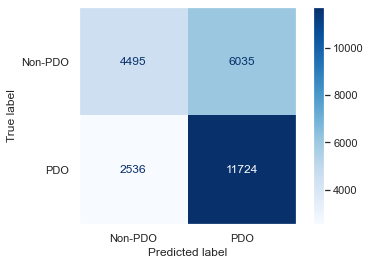

In [65]:
# plotting confusion matrix
plt.rcParams.update({'font.size': 12})
plot_confusion_matrix(log_reg, X_test_select, y_test, cmap=plt.cm.Blues)
plt.grid(b=None) # getting rid of the grids in the middle of the cells

In [66]:
# generating classification report
print(classification_report(y_test, yhat_log_reg))

              precision    recall  f1-score   support

     Non-PDO       0.64      0.43      0.51     10530
         PDO       0.66      0.82      0.73     14260

    accuracy                           0.65     24790
   macro avg       0.65      0.62      0.62     24790
weighted avg       0.65      0.65      0.64     24790



## Decision Tree Analysis

By playing with the model, we noticed that the best criterion is 'entropy' and the optimal tree depth is 5.

In [67]:
dec_tree = DecisionTreeClassifier(criterion='gini', max_depth=10, splitter='best') # initializing the model
dec_tree.fit(X_train_select, y_train) # fitting the model
yhat_dec_tree = dec_tree.predict(X_test_select) # calculating predicted classes

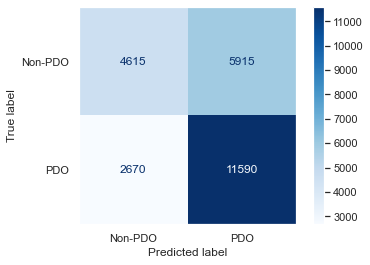

In [68]:
# plotting confusion matrix
plt.rcParams.update({'font.size': 12})
plot_confusion_matrix(dec_tree, X_test_select, y_test, cmap=plt.cm.Blues)
plt.grid(b=None) # getting rid of the grids in the middle of the cells

In [69]:
print(classification_report(y_test, yhat_dec_tree))

              precision    recall  f1-score   support

     Non-PDO       0.63      0.44      0.52     10530
         PDO       0.66      0.81      0.73     14260

    accuracy                           0.65     24790
   macro avg       0.65      0.63      0.62     24790
weighted avg       0.65      0.65      0.64     24790



## k-Nearest Neighbor

In [70]:
knn = KNeighborsClassifier(algorithm='ball_tree') # initializing the model
knn.fit(X_train_select, y_train.values.ravel()) # fitting the model
yhat_knn = knn.predict(X_test_select) # calculating predicted classes

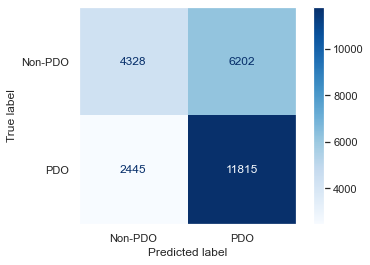

In [71]:
# plotting confusion matrix
plt.rcParams.update({'font.size': 12})
plot_confusion_matrix(knn, X_test_select, y_test, cmap=plt.cm.Blues)
plt.grid(b=None) # getting rid of the grids in the middle of the cells

In [72]:
print(classification_report(y_test, yhat_knn))

              precision    recall  f1-score   support

     Non-PDO       0.64      0.41      0.50     10530
         PDO       0.66      0.83      0.73     14260

    accuracy                           0.65     24790
   macro avg       0.65      0.62      0.62     24790
weighted avg       0.65      0.65      0.63     24790



# Discussions and Recommendations

This study analyzed the vehicle collisions and the resulting injury severity in nearly 100,000 collisions from 2015 to 2019 in unincorporated Sacramento County in California. Collision data were split based on the injury severity outcome to two classes: property damage only (PDO) and non-PDO. Three models, including logistic regression, decision tree, and kNN, were nominated to fit the data. The models were evaluated using precision, recall, F1-score, and accuracy. 

As can be seen from the performance evaluation metrics, all the models provide a similar accuracy of 0.65. Given the importance of the prediction of Non-PDO collisions, we do care more about recall than precision. Accordingly, Decision Tree provides a slightly better result, though negligible. The f1-score for Decision Tree for Non-PDO collisions is also slightly better.

As you can see, even the best model has still room for improvement. We can improve the performance of our models using a variety of methods and techniques. The initial guess is that we could have segregated the data more based on the severity outcome. While it will leave us an imbalanced dataset, we can employ oversampling techniques, such as SMOTE, to overcome this issue. Other methods that we can consider include feature engineering, other feature selection methods (such as PCA), using other algorithms, and ensemble methods. We will explore some of these techniques later.

If you have any questions about any part of the data, do not hesitate to reach out to me at mahdipn[at]gmail[dot]com.

Enjoy coding!